In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:131:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 0.04s
⚠️ Warning: Failed to set rpath for /home/wint3rmute/code/luthier/target/debug/libluthier.so: Failed to execute 'patchelf', did you install it? Hint: Try `pip install maturin[patchelf]` (or just `pip install patchelf`)
📦 Built wheel for CPython 3.10 to /tmp/.tmp7VWXJY/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR, LowPassFilter, SquareOscillator, Reverb, SawOscillator
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import differential_evolution
import random
import numpy as np
from IPython.display import clear_output

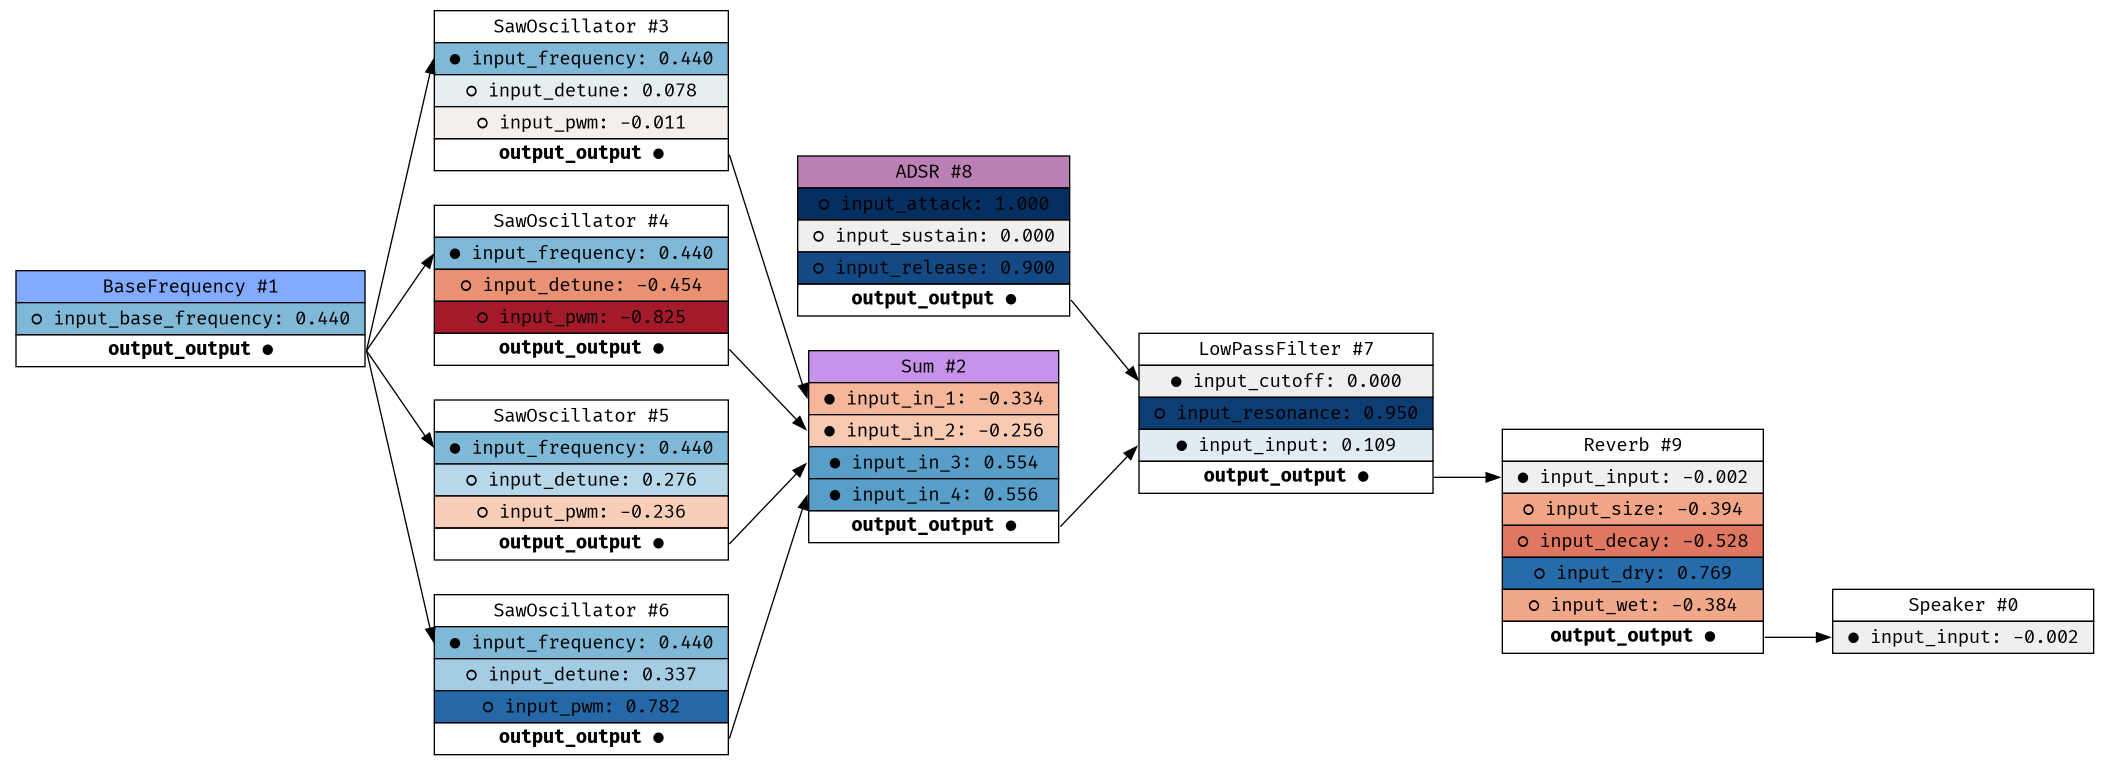

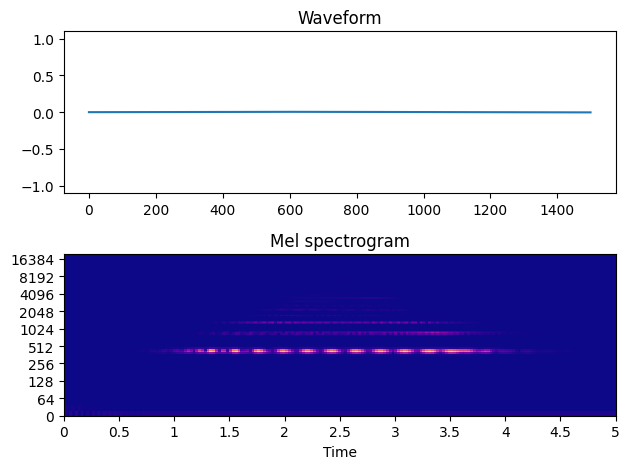

In [40]:
def add_square_with_detune(graph):
    s = SawOscillator()
    s.input_pwm = 0.3
    s = graph.add_saw(s)
    graph.patch(graph.base_frequency_node_id, "output_output", s, "input_frequency")
    
    return s

def fat_analog():
    graph = DspGraph()

    mixer = graph.add_sum(Sum())

    s1 = add_square_with_detune(graph)
    s2 = add_square_with_detune(graph)
    s3 = add_square_with_detune(graph)
    s4 = add_square_with_detune(graph)
    
    graph.patch(s1, "output_output", mixer, "input_in_1")
    graph.patch(s2, "output_output", mixer, "input_in_2")
    graph.patch(s3, "output_output", mixer, "input_in_3")
    graph.patch(s4, "output_output", mixer, "input_in_4")

#     mult = Multiplier()
#     mult.input_scale = 0.3
#     mult = graph.add_multiplier(mult)

    filter_adsr = ADSR()
    f = LowPassFilter()
    f.input_cutoff = 0.6
    f = graph.add_lowpass(f)
    filter_adsr = graph.add_adsr(filter_adsr)
    
    r = Reverb()
    r = graph.add_reverb(r)
    
    graph.patch(filter_adsr, "output_output", f, "input_cutoff")
    graph.set_input(graph.base_frequency_node_id, "input_base_frequency", 0.440)
    
    # graph.patch(mixer, "output_output", mult, "input_input")
    graph.patch(mixer, "output_output", f, "input_input")
    graph.patch(f, "output_output", r, "input_input")
    graph.patch(r, "output_output", graph.speaker_node_id, "input_input")
    
    return graph

graph = fat_analog()
graph.randomize_inputs()
graph.set_input(7, "input_resonance", 0.95)
graph.set_input(8, "input_attack", 1.0)
graph.set_input(8, "input_sustain", 0.0)
graph.set_input(8, "input_release", 0.9)
audio = Sample(graph.play(SAMPLE_RATE*5))
target_audio = audio
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax, 1500)
audio.plot_spectrogram(ax2)
audio.show_player()
plt.tight_layout()
plt.show()
target_audio = audio

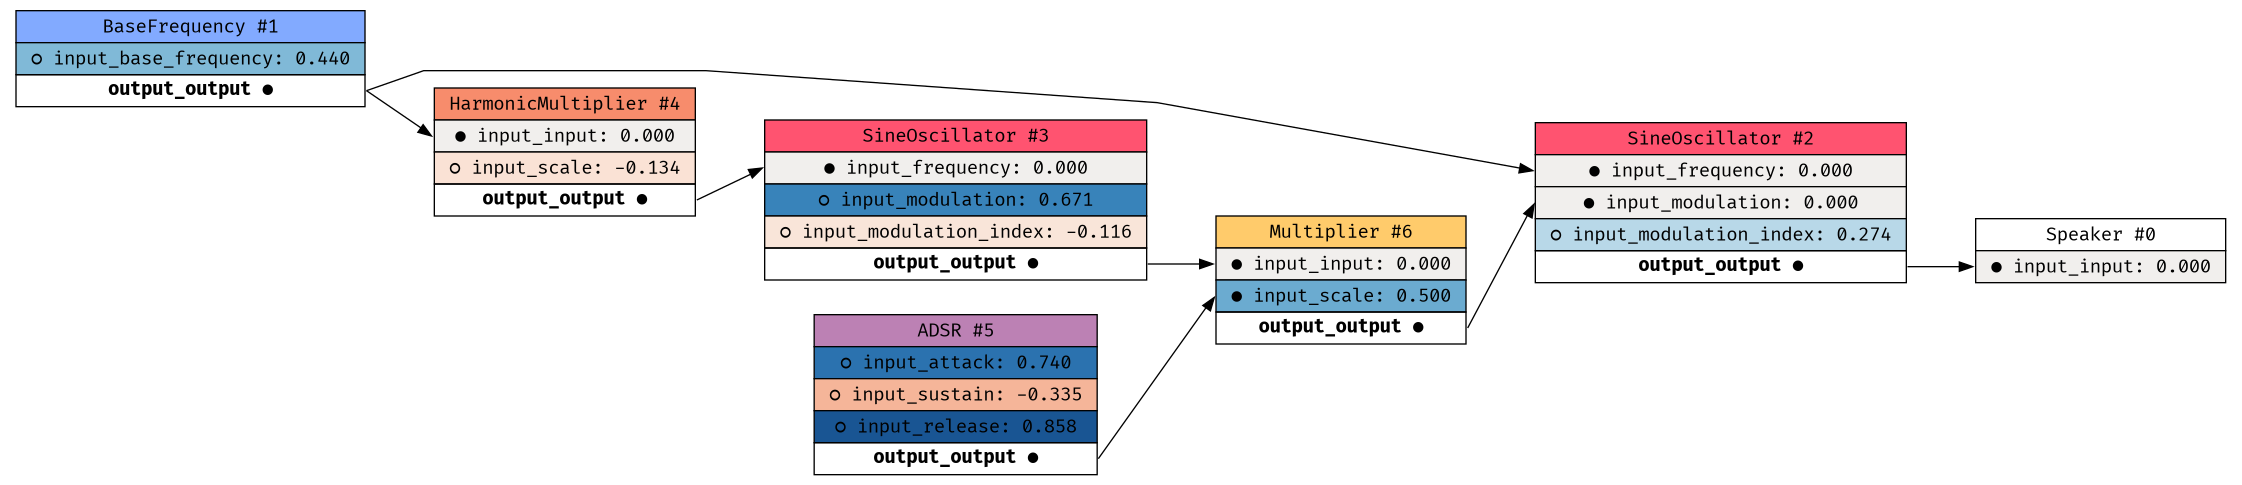

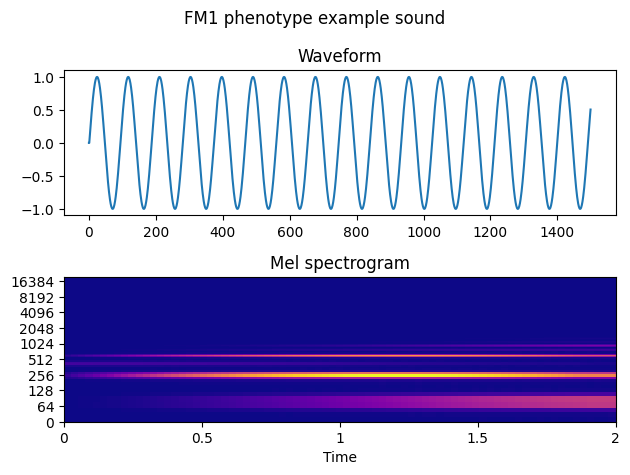

In [4]:
def fm_1(graph: DspGraph):
    """Single operator, single carrier FM"""
    
    carrier = graph.add_sine(SineOscillator())
    modulator = graph.add_sine(SineOscillator())
    
    carrier_multiplier = graph.add_harmonic_multiplier(HarmonicMultiplier())
    
    graph.patch(graph.base_frequency_node_id, "output_output", carrier_multiplier, "input_input")
    graph.patch(carrier_multiplier, "output_output", modulator, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    mod_adsr = graph.add_adsr(ADSR())
    mod_strength_multiplier = graph.add_multiplier(Multiplier())
    graph.patch(mod_adsr, "output_output", mod_strength_multiplier, "input_scale")
    graph.patch(modulator, "output_output", mod_strength_multiplier, "input_input")
    graph.patch(mod_strength_multiplier, "output_output", carrier, "input_modulation")
    
    return carrier
    
    
graph = DspGraph()
fm1_source = fm_1(graph)

graph.patch(fm1_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()
# todo: remove
# graph.set_input(2, "input_modulation_index", 0.0)
display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*2))

audio.plot_sound_overview("FM1 phenotype example sound")

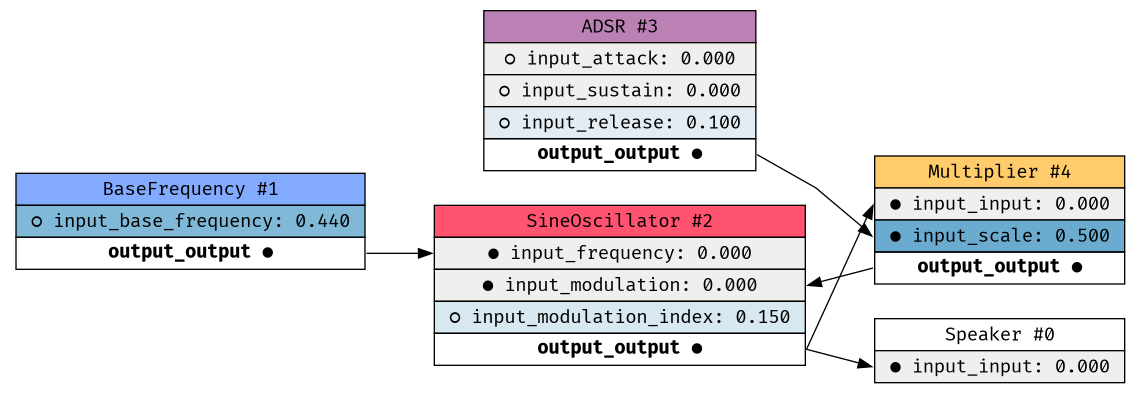

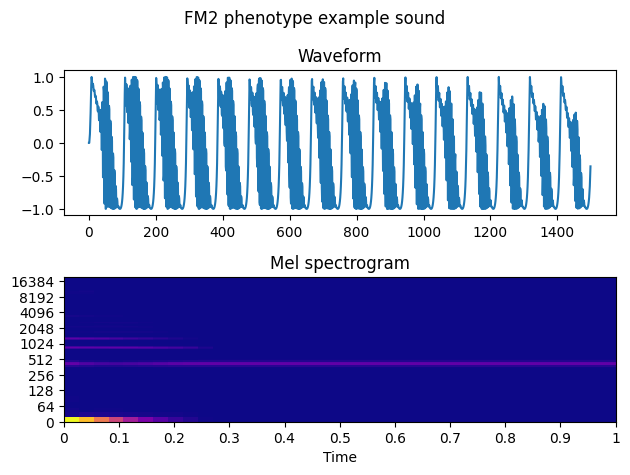

In [5]:
def fm_2(graph: DspGraph):
    """Single operator with feedback"""
    
    carrier = graph.add_sine(SineOscillator())
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    
    mod_adsr = graph.add_adsr(ADSR())
    mod_strength_multiplier = graph.add_multiplier(Multiplier())
    
    graph.patch(mod_adsr, "output_output", mod_strength_multiplier, "input_scale")
    graph.patch(carrier, "output_output", mod_strength_multiplier, "input_input")
    graph.patch(mod_strength_multiplier, "output_output", carrier, "input_modulation")
    
    return carrier
    
    
graph = DspGraph()

fm2_source = fm_2(graph)
graph.patch(fm2_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

# Cheating to avoid whirling sounds
graph.set_input(3, "input_attack", 0.0)
graph.set_input(3, "input_release", 0.1)
graph.set_input(3, "input_sustain", 0.0)
graph.set_input(2, "input_modulation_index", 0.15)

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("FM2 phenotype example sound")

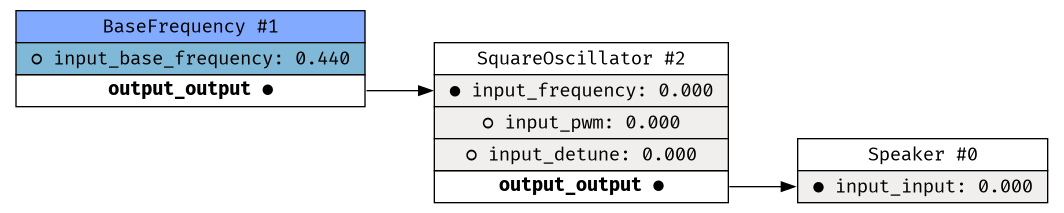

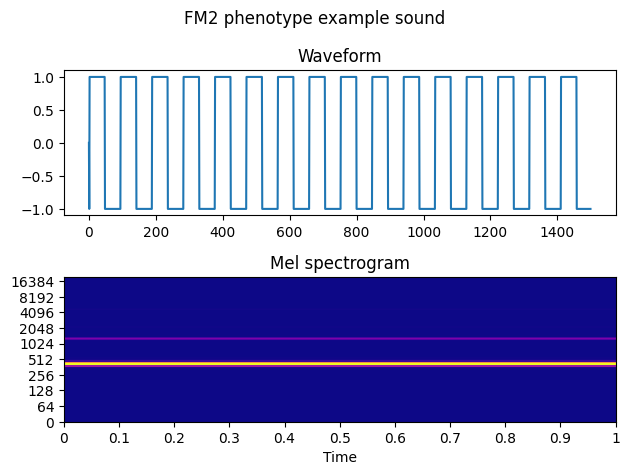

In [6]:
def an_1(graph: DspGraph):
    """Square wave with detune"""
    
    square = graph.add_square(SquareOscillator())
    graph.patch(graph.base_frequency_node_id, "output_output", square, "input_frequency")
    
    return square
    
    
graph = DspGraph()

an1_source = an_1(graph)
graph.patch(an1_source, "output_output", graph.speaker_node_id, "input_input")
# graph.randomize_inputs()

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("FM2 phenotype example sound")

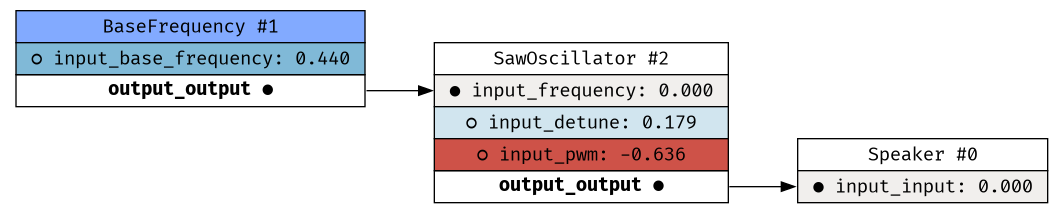

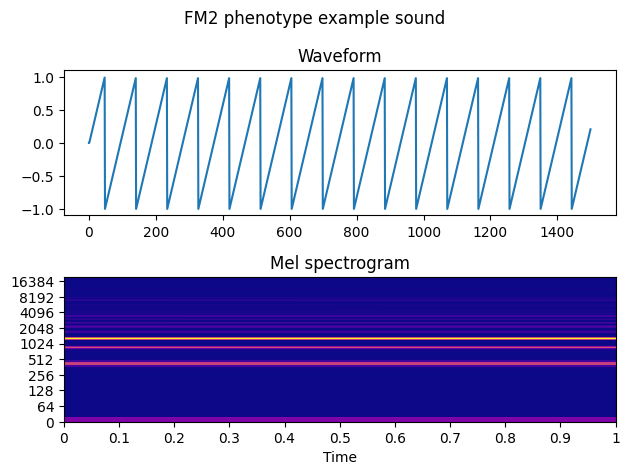

In [7]:
def an_2(graph: DspGraph):
    """Sawtooth wave with detune"""
    
    square = graph.add_saw(SawOscillator())
    graph.patch(graph.base_frequency_node_id, "output_output", square, "input_frequency")
    
    return square
    
    
graph = DspGraph()

an2_source = an_2(graph)
graph.patch(an2_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("FM2 phenotype example sound")

In [8]:
def select_from_array(value: float, array):
    value = ( value + 1.0 ) / 2.0 # Normalise ranging from -1 to 1
    return array[int(value * len(array) - 1.0)]

def make_source(g: DspGraph, source_selector):
    fun = select_from_array(source_selector, [fm_1, fm_2, an_1, an_2, do_nothing])
    return fun(g)

def do_nothing(g: DspGraph):
    pass

def build_graph_source_section(graph: DspGraph, params):
    mixer = graph.add_sum(Sum())
    
    source_1 = make_source(graph, params[0])
    source_2 = make_source(graph, params[0])
    source_3 = make_source(graph, params[0])
    source_4 = make_source(graph, params[0])
    
    if source_1:
        graph.patch(source_1, "output_output", mixer, "input_in_1")
    if source_2:
        graph.patch(source_2, "output_output", mixer, "input_in_2")
    if source_3:
        graph.patch(source_3, "output_output", mixer, "input_in_3")
    if source_4:
        graph.patch(source_4, "output_output", mixer, "input_in_4")
    
    return mixer

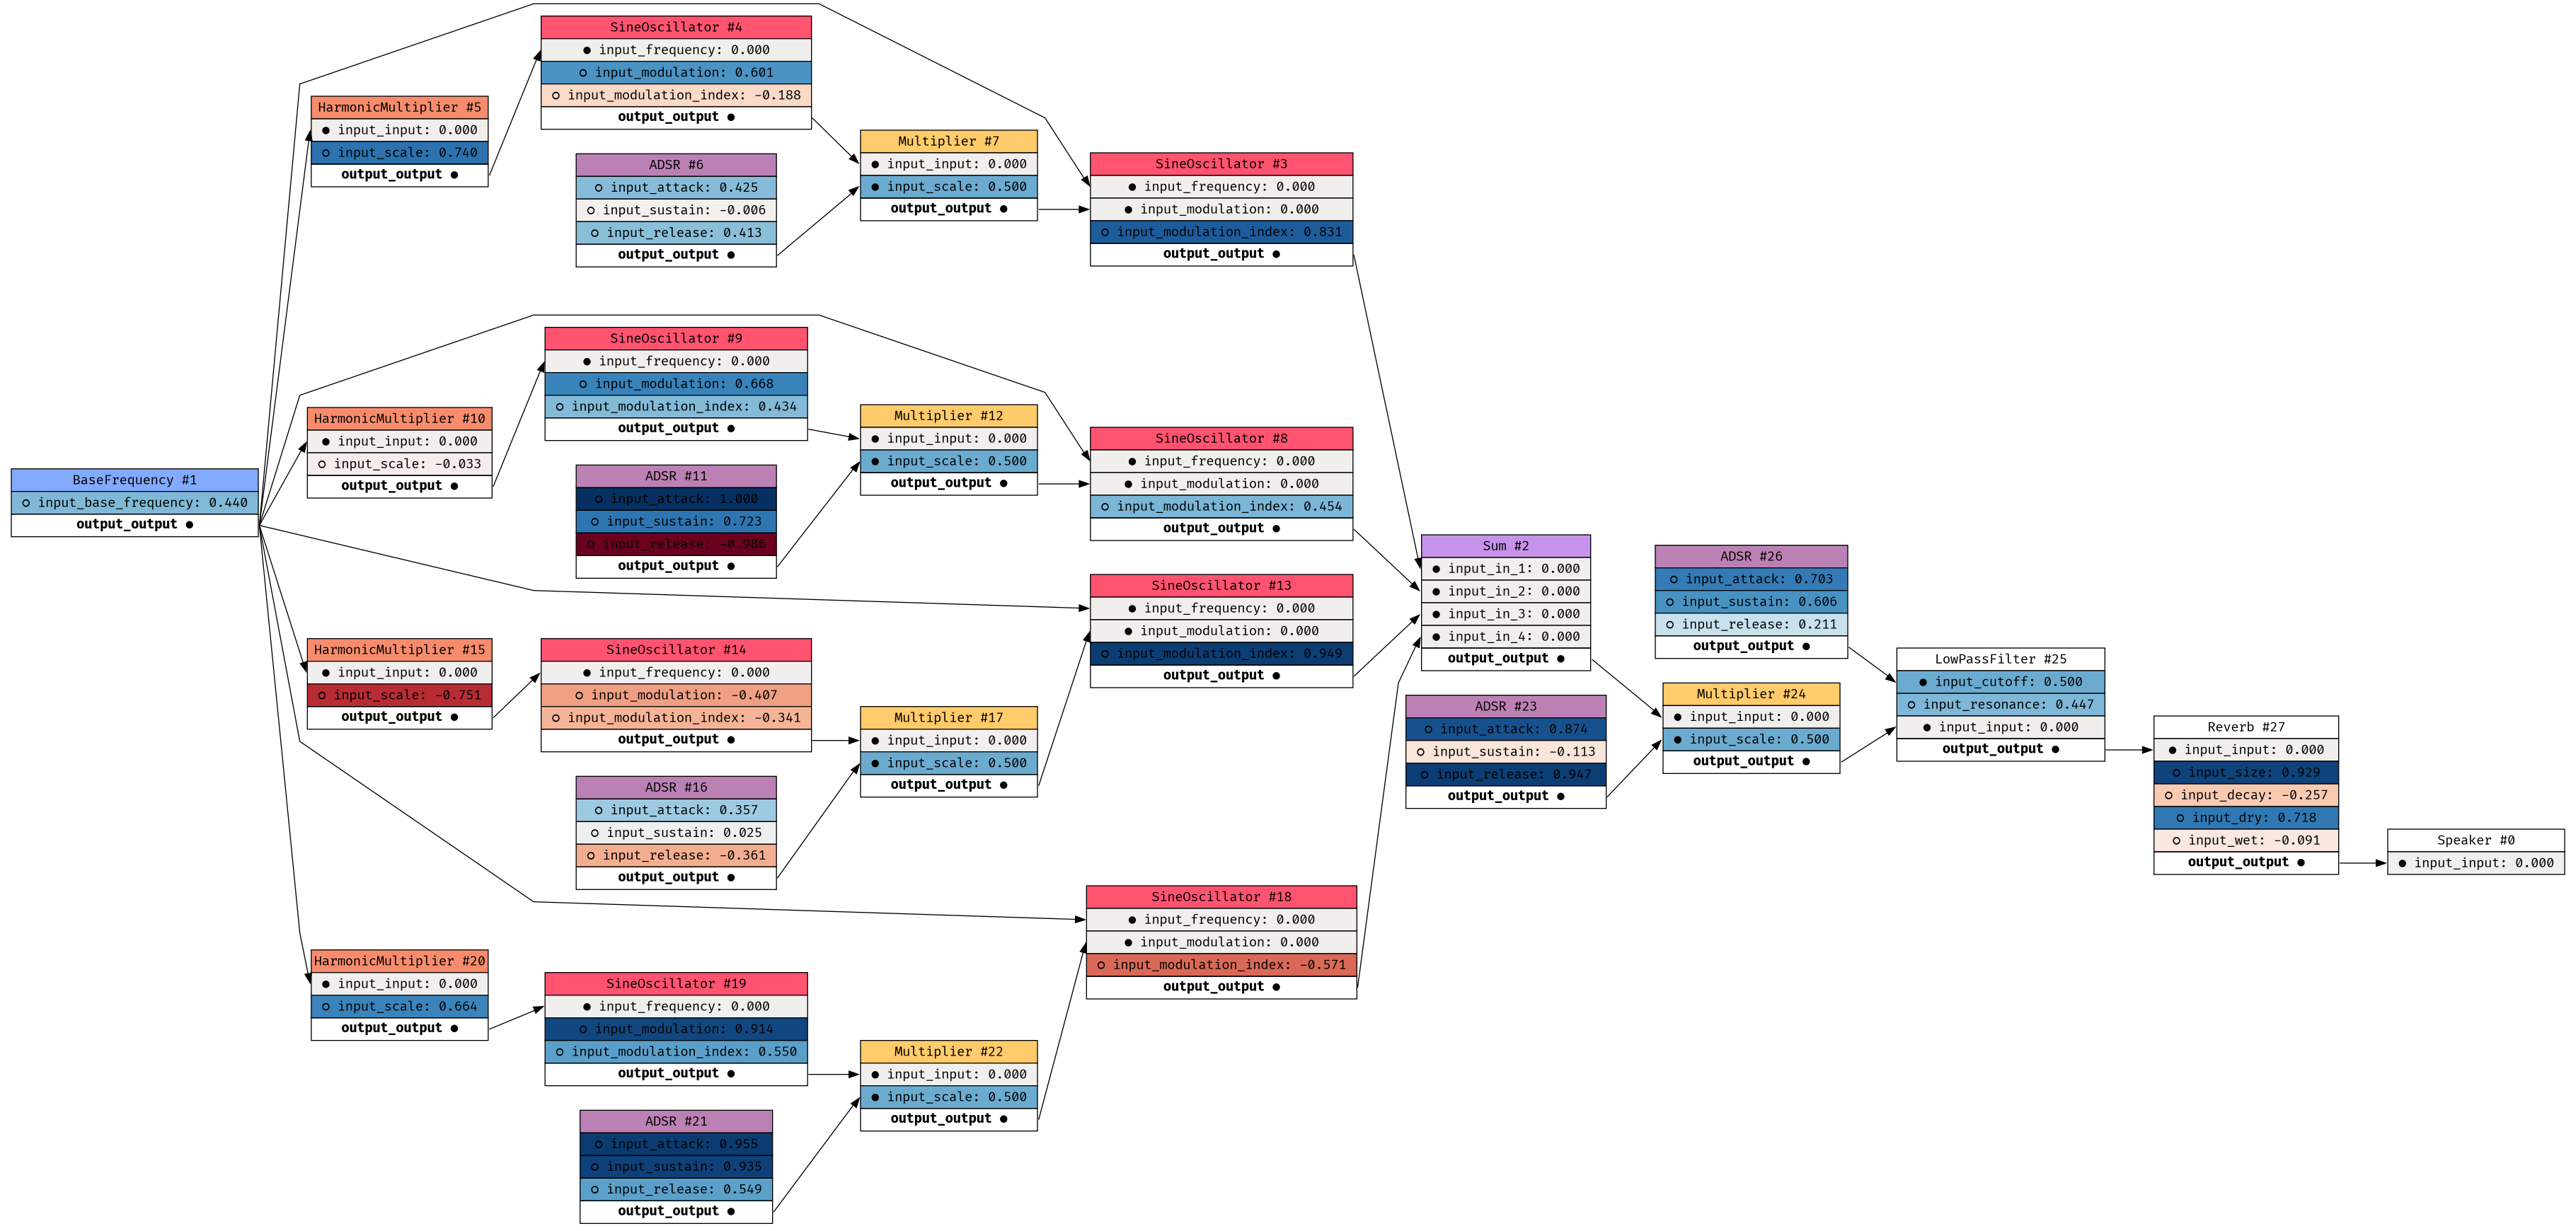

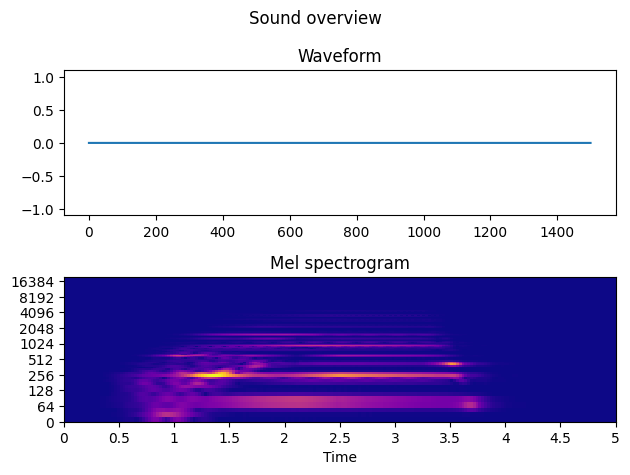

In [42]:
def build_graph_from_params(params):
    graph = DspGraph()
    
    structure_genotype = params[:10]
    params_genotype = params[10:]

    mixer = build_graph_source_section(graph, structure_genotype)
    amp_adsr = graph.add_adsr(ADSR())
    mixer_amp = graph.add_multiplier(Multiplier())

    graph.patch(amp_adsr, "output_output", mixer_amp, "input_scale")
    graph.patch(mixer, "output_output", mixer_amp, "input_input")

    lowpass = graph.add_lowpass(LowPassFilter())
    filter_adsr = graph.add_adsr(ADSR())
    graph.patch(filter_adsr, "output_output", lowpass, "input_cutoff")
    graph.patch(mixer_amp, "output_output", lowpass, "input_input")
    
    reverb = graph.add_reverb(Reverb())
    graph.patch(lowpass, "output_output", reverb, "input_input")
    graph.patch(reverb, "output_output", graph.speaker_node_id, "input_input")
    
    graph.set_inputs( params_genotype[:graph.num_inputs()] )
    
    return graph
    
    
params = np.array([random.uniform(-1, 1) for _ in range(50)])
graph = build_graph_from_params(params)

display(Image(graph.draw()))
audio = Sample(graph.play(SAMPLE_RATE * 5))
audio.plot_sound_overview()

In [ ]:
# target_audio = fm_sample

MAX_ITERATIONS = 30
POPULATION_SIZE = 50

def target_function(x):
    graph = build_graph_from_params(x)
    # graph.set_inputs(x)
    generated_audio = Sample(graph.play(len(target_audio)))
    dist = target_audio.mfcc_distance(generated_audio)
    
    return dist

def show_comparison(x):
    graph = build_graph_from_params(x)
    # graph.set_inputs(x)

    generated_audio = Sample(graph.play(num_samples = SAMPLE_RATE * 1))
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

    generated_audio.show_player()
    target_audio.show_player()

    generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
    generated_audio.plot_waveform(ax5, title="Trained waveform")
    generated_audio.plot_mfcc(ax3, title="Trained MFCC")

    target_audio.plot_spectrogram(ax2, title="Target spectrogram")
    target_audio.plot_waveform(ax6, title="Target waveform")
    target_audio.plot_mfcc(ax4, title="Target MFCC")

    fig.tight_layout()
    # plt.savefig(f'{time.time()}.png')
    plt.show()

target_fun_values = []
def callback(x, convergence):
    target_fun = target_function(x)
    target_fun_values.append(target_fun)
    clear_output()
    show_comparison(x)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = 50
print("Solving for num inputs", num_params)
solution = differential_evolution(
    target_function,
    [ (-1, 1) for i in range(num_params) ],
    workers=8,
    maxiter=MAX_ITERATIONS,
    popsize=POPULATION_SIZE,
    polish=False,
    disp=False,
    callback=callback
)
print(solution)

Solving for num inputs 50


/home/wint3rmute/code/luthier/.venv/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
